In [ ]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-07-07 20:21:53,200 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-07 20:21:53,201 - settings - Setting database.user to celiib
INFO - 2021-07-07 20:21:53,203 - settings - Setting database.password to newceliipass
INFO - 2021-07-07 20:21:53,203 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-07 20:21:53,204 - settings - Setting database.user to celiib
INFO - 2021-07-07 20:21:53,204 - settings - Setting database.password to newceliipass
INFO - 2021-07-07 20:21:53,220 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/de

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-07-07 20:21:53,744 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-07 20:21:53,804 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-07 20:21:53,805 - settings - Setting database.user to celiib
INFO - 2021-07-07 20:21:53,805 - settings - Setting database.password to newceliipass
INFO - 2021-07-07 20:21:53,806 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-07 20:21:54,403 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-07 20:21:54,586 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-07 20:21:54,587 - settings - Setting database.user to celiib
INFO - 2021-07-07 20:21:54,588 - settings - Setting database.password to newceliipass
INFO - 2021-07-07 20:21:54,588 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-07 20:21:54,589 - settings - Setting database.user to celiib
INFO - 2021-07-07 20:21:54,589 - settings - Setting database.pa

In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-07-07 20:21:55,413 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-07 20:21:55,415 - settings - Setting database.user to celiib
INFO - 2021-07-07 20:21:55,415 - settings - Setting database.password to newceliipass
INFO - 2021-07-07 20:21:55,418 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-07 20:21:56,039 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

# Getting the Results of the Validation

In [5]:
minnie.AutoProofreadValidationScore6()

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,189149,864691135855890478,0.08,0,=BLOB=,270.19864672128745,=BLOB=,=BLOB=,3,167,4,4,0.42857142857142855,0.42857142857142855,0.42857142857142855,5280,7,39,4,0.9926677946982515,0.9992429977289932,0.995944543996982,381.56
88.00,223037,864691136227167569,0.08,0,=BLOB=,108.89085932495647,=BLOB=,=BLOB=,0,450,0,0,nan,nan,nan,1,3416,3853,0,0.0002594706798131811,1.0,0.0005188067444876783,378.64
88.00,225498,864691135753932237,0.08,0,=BLOB=,287.0008022586593,=BLOB=,=BLOB=,11,72,5,0,0.6875,1.0,0.8148148148148148,1124,0,0,9,1.0,0.9920564872021183,0.9960124058484714,197.92
88.00,230236,864691135609687047,0.08,0,=BLOB=,1343.99235047008,=BLOB=,=BLOB=,27,549,12,23,0.6923076923076923,0.54,0.6067415730337079,1960,22,1,2,0.9994900560938297,0.9989806320081549,0.99923527912312,958.53
88.00,236197,864691136903144370,0.08,0,=BLOB=,40.753447012345966,=BLOB=,=BLOB=,0,974,0,6,nan,0.0,nan,2750,2333,3,48,0.9989102796948783,0.9828448892065761,0.9908124662223023,452.21
88.00,258307,864691135293126156,0.08,0,=BLOB=,597.8867829872936,=BLOB=,=BLOB=,7,352,0,63,1.0,0.1,0.18181818181818182,2983,8,24,20,0.9920186232125041,0.9933399933399933,0.9926788685524126,447.23
88.00,262773,864691136023889209,0.08,0,=BLOB=,199.5769705659838,=BLOB=,=BLOB=,10,47,2,0,0.8333333333333334,1.0,0.9090909090909091,724,0,2,10,0.9972451790633609,0.9863760217983651,0.9917808219178083,122.48
88.00,264870,864691136951664863,0.08,0,=BLOB=,930.3046613475068,=BLOB=,=BLOB=,28,424,0,4,1.0,0.875,0.9333333333333333,2008,26,3,33,0.9985082048731975,0.9838314551690348,0.9911154985192497,634.85
88.00,269247,864691135584074360,0.08,0,=BLOB=,886.6764688014647,=BLOB=,=BLOB=,80,14,0,190,1.0,0.2962962962962963,0.45714285714285713,802,0,7,69,0.9913473423980222,0.9207807118254879,0.9547619047619047,481.19
88.00,269380,864691135974639471,0.08,0,=BLOB=,363.9333366753406,=BLOB=,=BLOB=,14,254,7,24,0.6666666666666666,0.3684210526315789,0.4745762711864407,1863,4,8,3,0.9957242116515232,0.9983922829581994,0.9970564624029972,377.2


In [6]:
training_set = minnie.AutoProofreadValidationSegment.proj(old_segment_id="segment_id").fetch("old_segment_id")
training_set      

array([864691134988386682, 864691135113167769, 864691135212632448,
       864691135212690816, 864691135233108569, 864691135272164113,
       864691135348272855, 864691135382947307, 864691135393964789,
       864691135407289801, 864691135491233631, 864691135501578306,
       864691135510455760, 864691135564655959, 864691135589906955,
       864691135589907979, 864691135645592260, 864691135699269154,
       864691135735426708, 864691135736387732, 864691135737374100,
       864691135740225387, 864691135748568361, 864691135748575017,
       864691135771629819, 864691135785277636, 864691135865518469,
       864691135866394390, 864691135925564174, 864691135945413668,
       864691135974454383, 864691135974454639, 864691135974454895,
       864691136003930314, 864691136008425132, 864691136008573614,
       864691136056340440, 864691136056391384, 864691136099807093,
       864691136105484249, 864691136105491417, 864691136105493209,
       864691136105498585, 864691136134446219, 864691136175008

In [19]:
validation_table_pd = vu.current_validation_df()

INFO - 2021-07-07 20:31:49,463 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-07 20:31:49,465 - settings - Setting database.user to celiib
INFO - 2021-07-07 20:31:49,466 - settings - Setting database.password to newceliipass
INFO - 2021-07-07 20:31:49,470 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-07 20:31:50,437 - settings - Setting enable_python_native_blobs to True


In [20]:
import system_utils as su

In [21]:
su.compressed_pickle(validation_table_pd,"validation_table_pd_7_7_adjusted_axon_spines")

Saved object at /neuron_mesh_tools/Auto_Proofreading/Validation_Testing/v4_unseen/validation_table_pd_7_7_adjusted_axon_spines.pbz2
File size is 35.245437 MB


# On Training Set

Segment Id = 864691134988386682
Postsyn counts:
TP:202991
TN:1133
FP:321
FN:1580
Presyn counts:
TP:1418
TN:9893
FP:178
FN:887


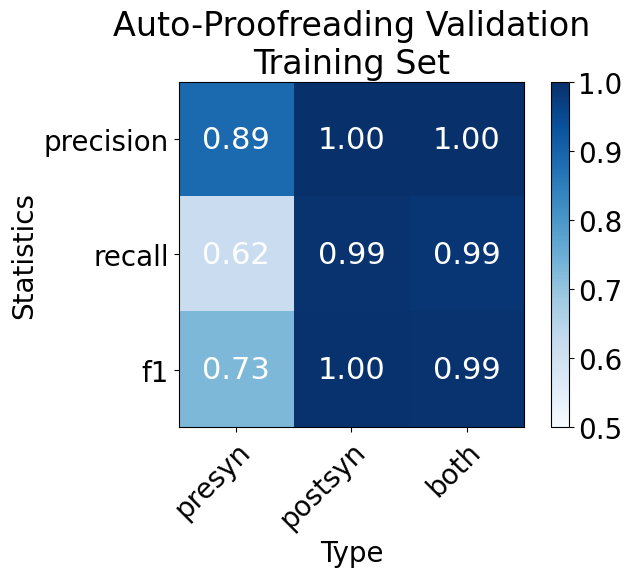

In [22]:
training_df = validation_table_pd[validation_table_pd["old_segment_id"].isin(training_set)]
vu.validation_df_to_score_plot(training_df,
                              title_append = "Training Set")

# With the held out neurons

In [23]:
held_out_df = validation_table_pd[~validation_table_pd["old_segment_id"].isin(training_set)]

Segment Id = 864691134988385914
Postsyn counts:
TP:315564
TN:117185
FP:10501
FN:8469
Presyn counts:
TP:714
TN:17053
FP:163
FN:460


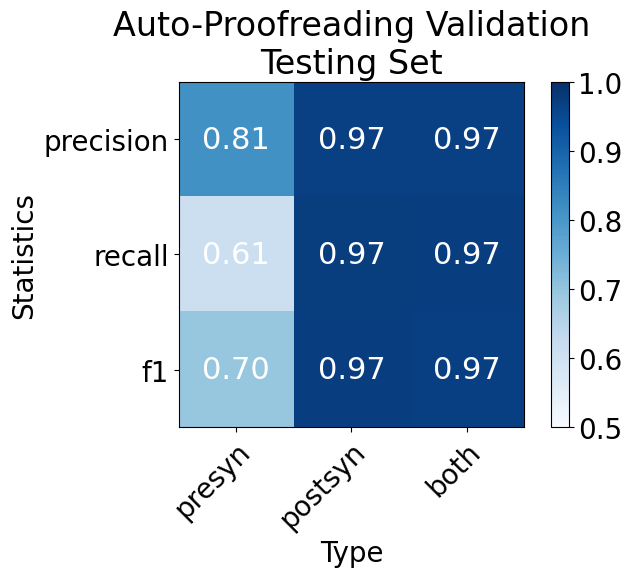

In [24]:
vu.validation_df_to_score_plot(held_out_df,title_append = "Testing Set")

In [25]:
n_somas,n_glia = held_out_df["n_somas"].to_numpy(),held_out_df["n_glia"].to_numpy()

In [26]:
n_somas

array([1, 2, 2, 1, 2, 1, 1, 1, 1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 4, 1, 2, 1, 1, 1, 2, 2,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1])

In [27]:
n_glia

array([0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [28]:
len(np.where(n_somas>1)[0])/len(n_somas)

0.3333333333333333

In [29]:
np.sum(n_glia)

4

# Overall Accuracy

Segment Id = 864691134988385914
Postsyn counts:
TP:518555
TN:118318
FP:10822
FN:10049
Presyn counts:
TP:2132
TN:26946
FP:341
FN:1347


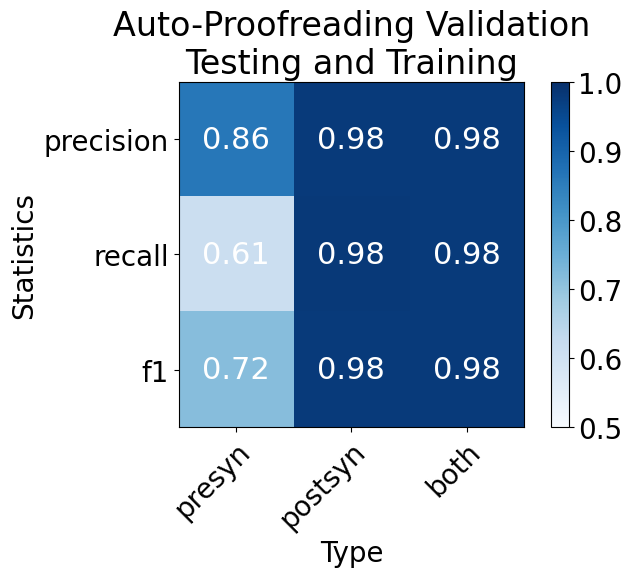

In [30]:
vu.validation_df_to_score_plot(validation_table_pd,
                              title_append = "Testing and Training")

# on the training set

In [ ]:
curr_table2 = ((minnie.AutoProofreadValidationScore5() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table2

In [ ]:
(curr_table2 & dict(segment_id=864691136378815445)).fetch1("decomposition")

In [ ]:
curr_table = ((minnie.AutoProofreadValidationScore4() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table

In [ ]:
seg_ids,pre_recall_v4 = curr_table.fetch("segment_id","pre_recall")
pre_recall_v5 = curr_table2.fetch("pre_recall")

In [ ]:
recall_diff = (pre_recall_v4 - pre_recall_v5)
indices_recall_diff = np.where(recall_diff > 0)[0]
print(recall_diff[indices_recall_diff])
print(seg_ids[indices_recall_diff])

In [ ]:
curr_table2 & dict(segment_id=864691135415666362)

In [ ]:
total_validation_df = vu.table_to_score_plot(curr_table,
                       return_validation_df=True)